In [171]:
%matplotlib inline

import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tqdm import tqdm
import gc

## Import Data

In [103]:
dtypes = {
    'comment_text': np.unicode,
    "toxic": np.float32,
    "severe_toxic": np.float32,
    "obscene": np.float32,
    "threat": np.float32,
    "insult": np.float32,
    "identity_hate": np.float32
}
train = pd.read_csv("data/train.csv", dtype=dtypes) #, encoding='utf-8'
test = pd.read_csv("data/test.csv", dtype=dtypes) # , encoding='utf-8'

train.comment_text.fillna("unknown", inplace=True)
test.comment_text.fillna("unknown", inplace=True)

In [137]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult",
           "identity_hate"]
train_data = train['comment_text']  
labels = train[classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

 ## This is used to represent the corpus in the format of a  dictionary where every index represent a unique word and it is arranged from the most frequent to the least frequent

In [105]:
type(list(list_sentences_train)[1])

str

In [138]:
max_features = 20000 # Number of unique words in the corpus, needs optimization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [139]:
word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))
word_count = tokenizer.word_counts
# print('Top 5 Frequent Words count. ' % word_count[5])

Found 153397 unique tokens.


In [140]:
print(tokenized_train[:1]) # Take a lot at the NN input

[[813, 4855, 200, 6773, 40, 7, 162, 8, 393, 234, 19, 20, 350, 14245]]


## This is done to normalize the length of the text sequences to the maxlen value

    This is called [Padding], it includes shortenning the long sentences and longing the short sentences by zeros so they equal the maxlen

In [141]:
maxlen = 200 # needs optimization
X = pad_sequences(tokenized_train, maxlen=maxlen)
X_t =pad_sequences(tokenized_test, maxlen=maxlen)

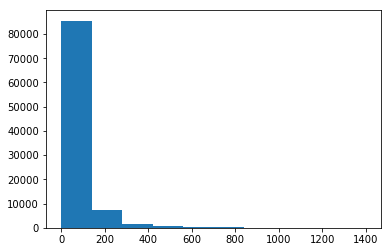

In [142]:
# Plot a histogram between the number of comments and the length of the comment
totalNumWords = [len(comment) for comment in tokenized_train]
plt.hist(totalNumWords) #, bins=np.range(0,500,10)
plt.show()

## Let's Start building the Model

<img src="images/txJomEa.png" >

In [143]:
# input is a list of encoded sentences, each sentence with a maxlen=200
input_layer = Input(shape=(maxlen, )) 

In [12]:
# Prepaing the Embedding Layer using Glove Word Vectors
embedding_index_glove = {}
f = open("../Sentiment_Model_Template/glove.840B.300d.txt")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index_glove[word] = coefs
f.close()
print('Found %s word vectors.' % len(embedding_index_glove))

2196017it [02:04, 17699.81it/s]

Found 2196016 word vectors.


In [48]:
train_data.shape[0]

95851

In [145]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.2

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * X.shape[0])

x_train = X[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = X[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


In [146]:
labels.shape

(95851, 6)

In [147]:
print (x_train.shape)
print (x_val.shape)
print (y_train.shape)
print (y_val.shape)

(76681, 200)
(19170, 200)
(76681, 6)
(19170, 6)


In [148]:
# prepare embedding matrix
EMBEDDING_DIM = 300
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [149]:
MAX_SEQUENCE_LENGTH = maxlen
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(input_layer)

# embedding_layer = Embedding(num_words,
#                             EMBEDDING_DIM,
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)(input_layer)


In [150]:
x = LSTM(units=60, return_sequences=True, name='lstm_layer')(embedding_layer)

In [151]:
x = GlobalMaxPool1D()(x)

## This is done to achive Generalization, by doing some kind of regualization called [Droupout] 
    Which is basiclly done by droping the learned weights of a neuron in a NN to zero (dropout_ate=0.1) means that 10% of the neurons/nodes weights will be dropped to zero every iteration

In [152]:
x = Dropout(rate=0.1)(x)

## A densely connected layer anf the output passes through a ReLU functin

In [153]:
x = Dense(units=50, activation="relu")(x)

In [154]:
x = Dropout(rate=0.1)(x)

## Output layer has an activation [Sigmoid] to reduce the probabilities to a real number between [0, 1]

In [155]:
x = Dense(units=6, activation="sigmoid")(x) 

In [162]:
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy']) #{'toxic': 'accuracy', 'severe_toxic': 'accuracy', 'obscene': 'accuracy',
                        #'threat': 'accuracy', 'insult': 'accuracy', 'identity_hate': 'accuracy'}) # 'accuracy'

In [163]:
batch_size = 32
epochs = 10
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Train on 76681 samples, validate on 19170 samples
Epoch 1/10
76681/76681 [==============================] - 358s - loss: 0.1426 - acc: 0.9634 - val_loss: 0.1447 - val_acc: 0.9621
Epoch 2/10
76681/76681 [==============================] - 356s - loss: 0.1422 - acc: 0.9634 - val_loss: 0.1450 - val_acc: 0.9621
Epoch 3/10
76681/76681 [==============================] - 362s - loss: 0.1418 - acc: 0.9634 - val_loss: 0.1450 - val_acc: 0.9621
Epoch 4/10
76681/76681 [==============================] - 379s - loss: 0.1408 - acc: 0.9634 - val_loss: 0.1456 - val_acc: 0.9621
Epoch 5/10
76681/76681 [==============================] - 376s - loss: 0.1404 - acc: 0.9634 - val_loss: 0.1463 - val_acc: 0.9621
Epoch 6/10
76681/76681 [==============================] - 352s - loss: 0.1405 - acc: 0.9634 - val_loss: 0.1486 - val_acc: 0.9621
Epoch 7/10
76681/76681 [==============================] - 349s - loss: 0.1395 - acc: 0.9634 - val_loss: 0.1463 - val_acc: 0.9621
Epoch 8/10
76681/76681 [=======================

In [164]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           86640     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [165]:
y_test = model.predict([X_t], batch_size=1024, verbose=1)

226998/226998 [==============================] - 205s   


In [166]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[classes] = y_test
sample_submission.to_csv('submissions/keras_lstm_submission.csv', index=False)


# A claimed improvement based on Jermey Howrad's [kernel](https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout)


In [167]:
all_embs = np.stack(embedding_index_glove.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0058384896, 0.48782218)

In [168]:
# prepare embedding matrix
EMBEDDING_DIM = 300
num_words = min(max_features, len(word_index) + 1)
embedding_matrix_modified = np.random.normal(emb_mean, emb_std, (num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_modified[i] = embedding_vector

In [169]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, EMBEDDING_DIM, weights=[embedding_matrix_modified])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_mod = Model(inputs=inp, outputs=x)
model_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [173]:
gc.collect()

0

In [174]:
batch_size = 32
epochs = 2
model_mod.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, 
              validation_data=(x_val, y_val))

Train on 76681 samples, validate on 19170 samples
Epoch 1/2
76681/76681 [==============================] - 885s - loss: 0.1468 - acc: 0.9631 - val_loss: 0.1446 - val_acc: 0.9621
Epoch 2/2
76681/76681 [==============================] - 795s - loss: 0.1410 - acc: 0.9634 - val_loss: 0.1461 - val_acc: 0.9621


In [175]:
model_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          140400    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306       
Total para

In [176]:
y_test_mod = model.predict([X_t], batch_size=1024, verbose=1)

226998/226998 [==============================] - 183s   


In [177]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission[classes] = y_test_mod
sample_submission.to_csv('submissions/keras_lstm_mod_submission.csv', index=False)

In [ ]:
# # Apossible altrnative architecture

# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
# embedded_sequences = embedding_layer(sequence_input)
# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
# x = Flatten()(x)
# x = Dense(128, activation='relu')(x)
# preds = Dense(len(labels_index), activation='softmax')(x)

# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])

# # happy learning!
# model.fit(x_train, y_train, validation_data=(x_val, y_val),
#           epochs=2, batch_size=128)
